In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ============================================================
# Load data
# ============================================================

CSV_PATH = "zgrab_unified.csv"

df = pd.read_csv(CSV_PATH)
good_df = df.loc[df["success"] == True]

# Quick preview
print(df.head())
print(df.shape)
print(good_df.head())
print(good_df.shape)

                         ip    asn               prefix country protocol  \
0    2001:19f0:6000:642::33  20473  2001:19f0:6000::/40      US     http   
1    2001:19f0:5c00:1d0::33  20473  2001:19f0:5c00::/40      US     http   
2          2001:1278:9:1::2  18734     2001:1278:9::/48      MX     http   
3  2001:470:1:21::403e:fa0a   6939        2001:470::/32     NaN     http   
4      2001:19f0:0:60c2::33  20473       2001:19f0::/40      US     http   

            server_header device_type  success  
0                     NaN     Unknown    False  
1                     NaN     Unknown    False  
2                     NaN     Unknown    False  
3  Apache/2.4.29 (Ubuntu)      Apache     True  
4                     NaN     Unknown    False  
(11556, 8)
                                        ip    asn               prefix  \
3                 2001:470:1:21::403e:fa0a   6939        2001:470::/32   
6                     2001:470:1:43b:1::72   6939        2001:470::/32   
7               

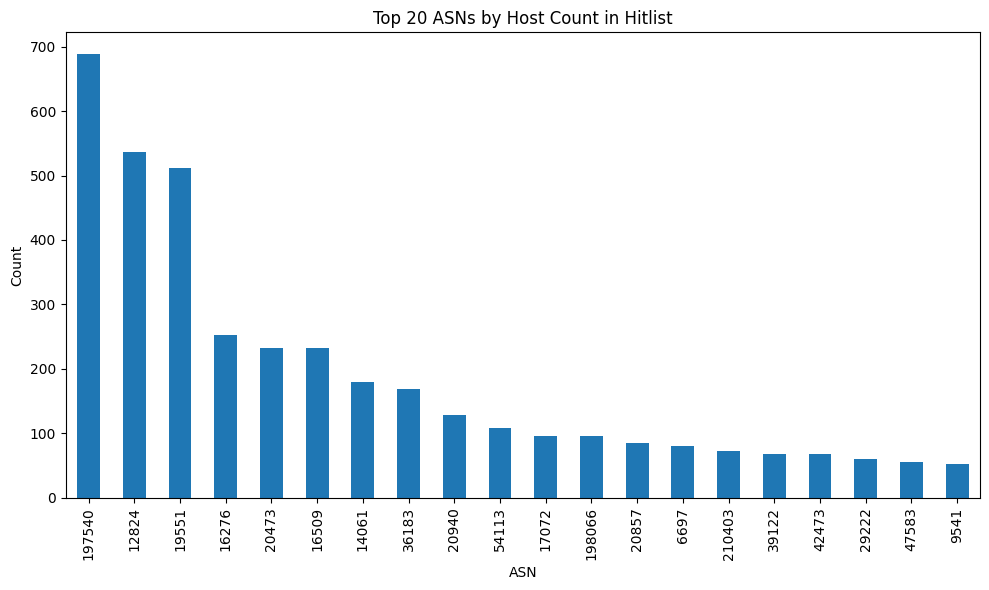

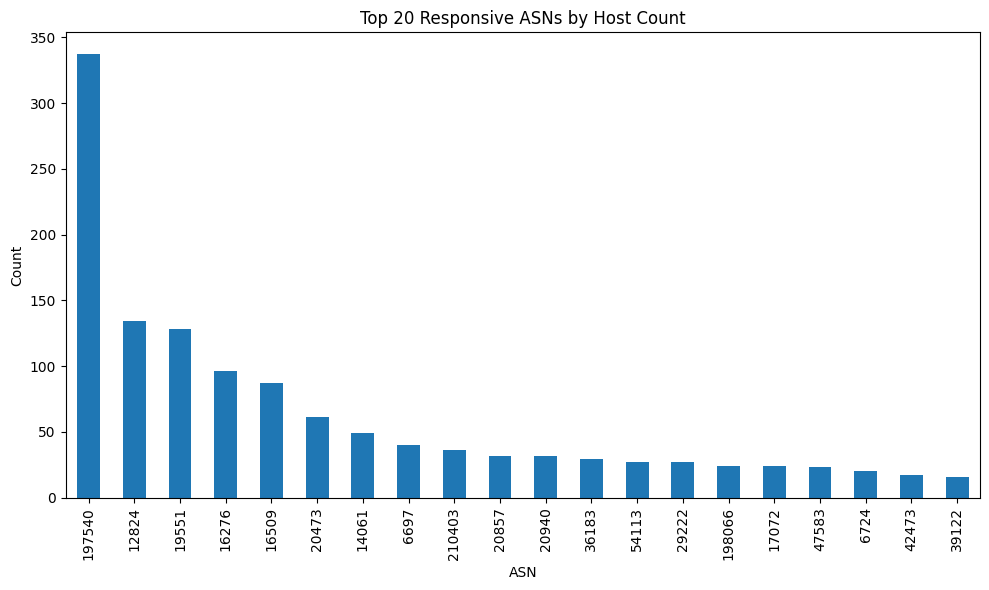

In [11]:
def get_top_asns(df, title):
    asns = df['asn'].dropna()

    top_asns = asns.value_counts().head(20)

    plt.figure(figsize=(10,6))
    top_asns.plot(kind='bar')
    plt.title(title)
    plt.xlabel("ASN")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

get_top_asns(df, "Top 20 ASNs by Host Count in Hitlist")
get_top_asns(good_df, "Top 20 Responsive ASNs by Host Count")

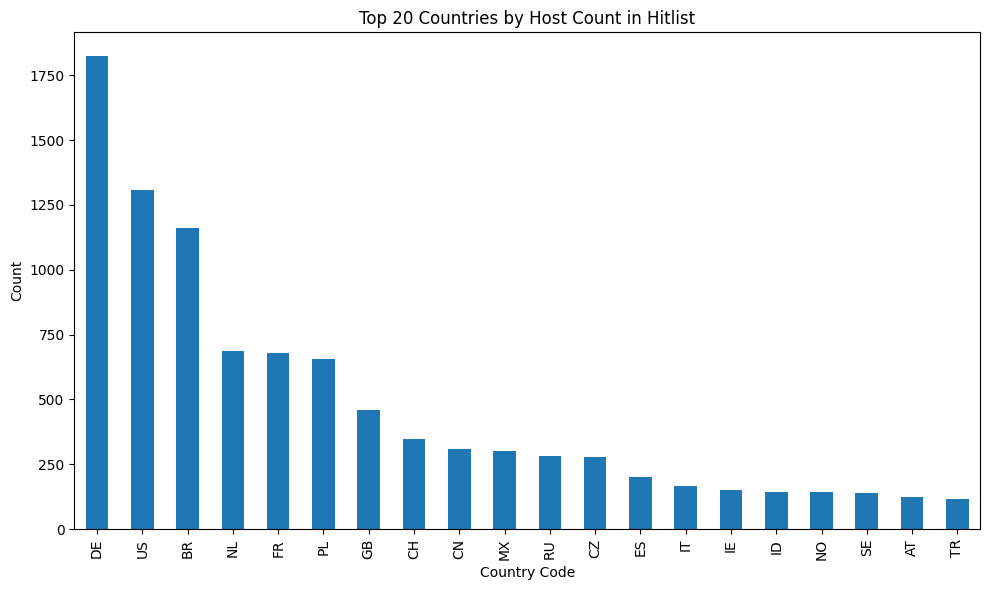

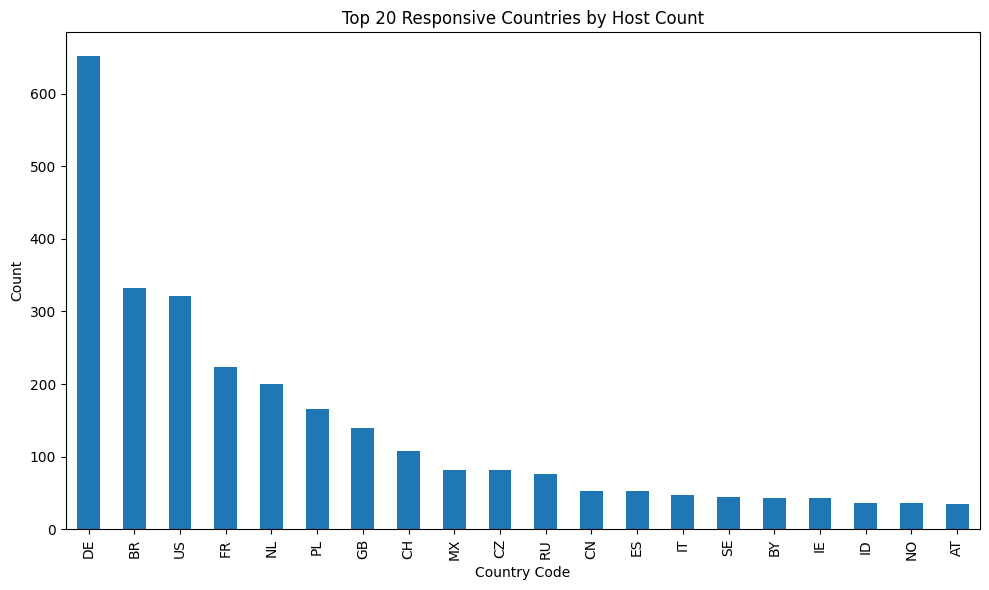

In [12]:
def get_top_countries(df, title):
    countries = df['country'].dropna()

    top_countries = countries.value_counts().head(20)

    plt.figure(figsize=(10,6))
    top_countries.plot(kind='bar')
    plt.title(title)
    plt.xlabel("Country Code")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

get_top_countries(df, "Top 20 Countries by Host Count in Hitlist")
get_top_countries(good_df, "Top 20 Responsive Countries by Host Count")

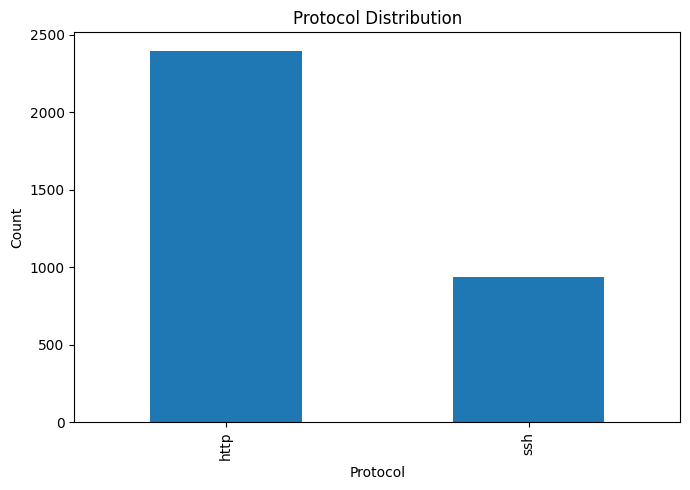

In [13]:
proto_counts = good_df['protocol'].value_counts()

plt.figure(figsize=(7,5))
proto_counts.plot(kind='bar')
plt.title("Protocol Distribution")
plt.xlabel("Protocol")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

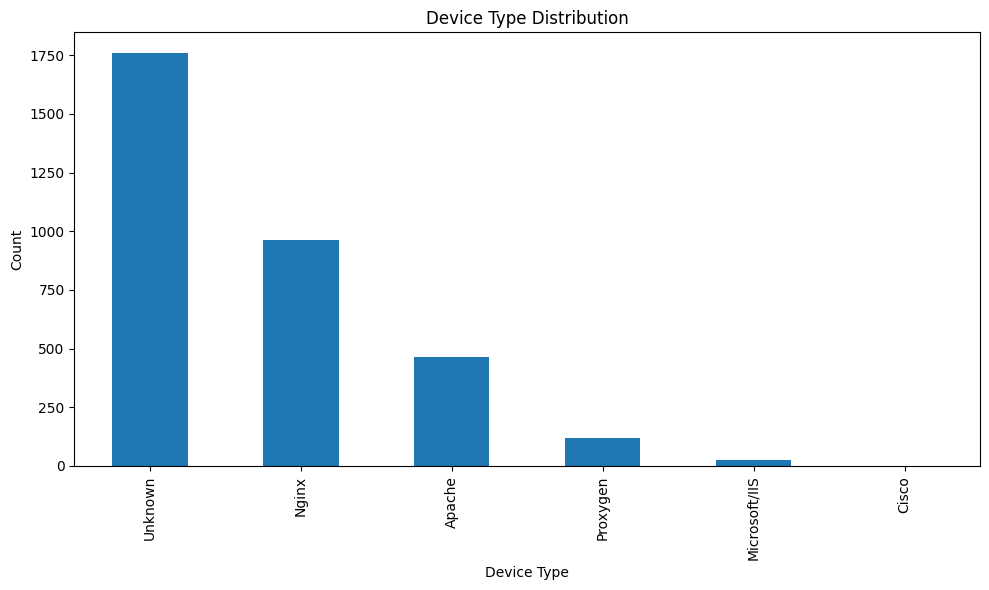

In [14]:
device_types = (
    good_df['device_type']
    .fillna("Unknown")
    .value_counts()
    .head(20)
)

plt.figure(figsize=(10,6))
device_types.plot(kind='bar')
plt.title("Device Type Distribution")
plt.xlabel("Device Type")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

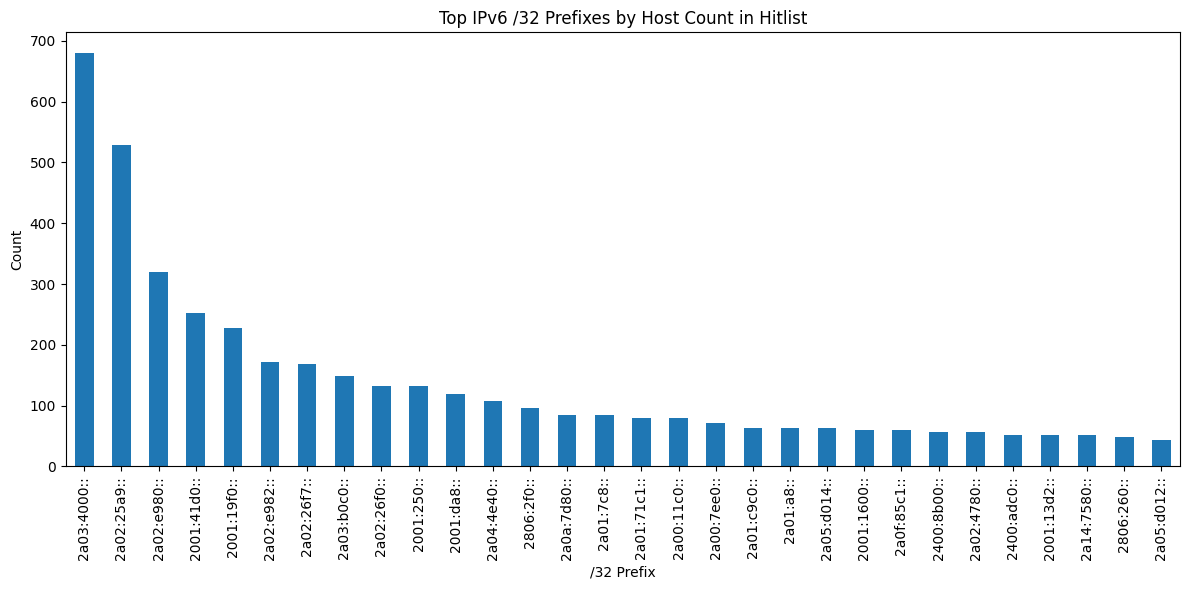

/tmp/ipykernel_194586/753922091.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['prefix32'] = df['ip'].apply(to_32_prefix)


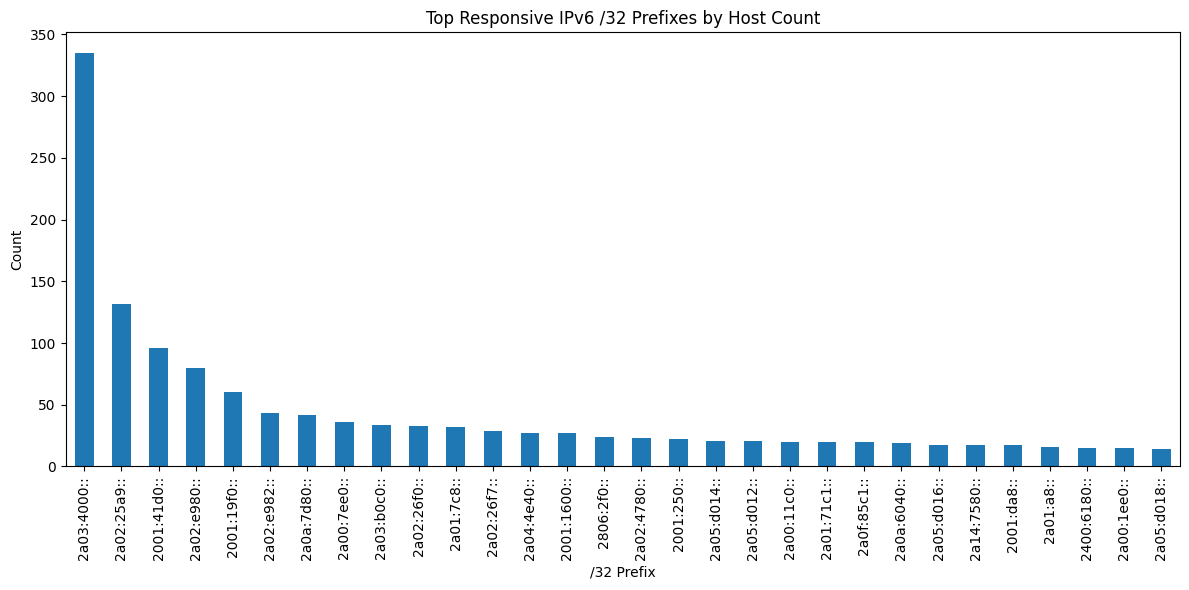

In [15]:
import ipaddress

# Extract /32 prefix from each IPv6 address
def to_32_prefix(ip):
    try:
        network = ipaddress.IPv6Network(ip + "/32", strict=False)
        return str(network.network_address)
    except:
        return None

def get_prefix_distribution(df, title):
    df['prefix32'] = df['ip'].apply(to_32_prefix)

    prefix_counts = df['prefix32'].value_counts().head(30)

    plt.figure(figsize=(12,6))
    prefix_counts.plot(kind='bar')
    plt.title(title)
    plt.xlabel("/32 Prefix")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

get_prefix_distribution(df, "Top IPv6 /32 Prefixes by Host Count in Hitlist")
get_prefix_distribution(good_df, "Top Responsive IPv6 /32 Prefixes by Host Count")

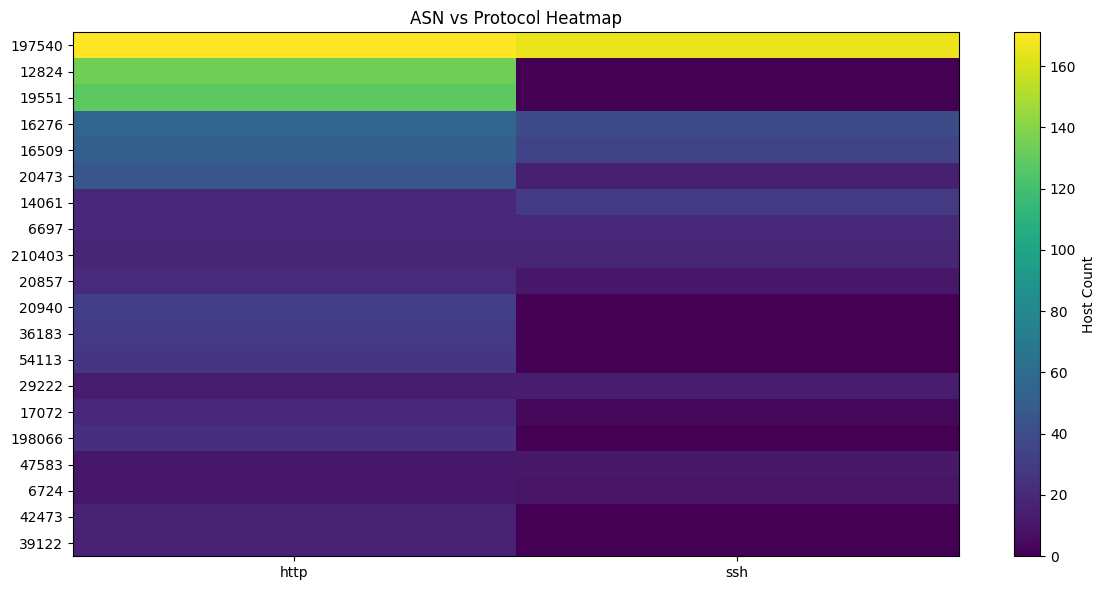

In [16]:
pivot = pd.pivot_table(
    good_df,
    values='ip',
    index='asn',
    columns='protocol',
    aggfunc='count',
    fill_value=0
)

top_asns = pivot.sum(axis=1).sort_values(ascending=False).head(20)
pivot_top = pivot.loc[top_asns.index]

plt.figure(figsize=(12,6))
plt.imshow(pivot_top, aspect='auto')
plt.colorbar(label='Host Count')
plt.xticks(range(len(pivot_top.columns)), pivot_top.columns)
plt.yticks(range(len(pivot_top.index)), pivot_top.index)
plt.title("ASN vs Protocol Heatmap")
plt.tight_layout()
plt.show()

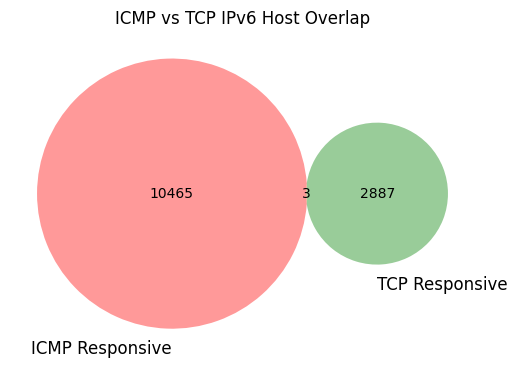

In [8]:
from matplotlib_venn import venn2

icmp_file = open("xmap_addr/icmp.txt", "r")
tcp_file = open("xmap_addr/tcp.txt", "r")

icmp_hosts = set(icmp_file.read().split("\n"))
tcp_hosts = set(tcp_file.read().split("\n"))

plt.figure(figsize=(6,6))
venn2([icmp_hosts, tcp_hosts],
      set_labels=("ICMP Responsive", "TCP Responsive"))
plt.title("ICMP vs TCP IPv6 Host Overlap")
plt.show()

In [9]:
intersection = len(icmp_hosts & tcp_hosts)
union = len(icmp_hosts | tcp_hosts)

jaccard = intersection / union
print("Jaccard Similarity:", jaccard)

Jaccard Similarity: 0.00022463496817671285
